In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data preparation

In [2]:
## IMDB Movie Dataset
ratings=pd.read_csv("./datasets/IMDB Movie dataset/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
ratings['parsed_time'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [4]:
## divide parsed_time into date and time 
import datetime as dt
a=np.array([dt.datetime.strftime(x,'%Y-%m-%d %H:%M').split() for x in ratings['parsed_time']])
ratings["date"]=a[:,0]

In [5]:
## dividing date into year, month and adding them to the dataset as three columns 
b=np.array([x.split("-") for x in a[:,0]])
ratings["year"]=b[:,0]
ratings["month"]=b[:,1]
ratings["day"]=b[:,2]

In [6]:
## removing data related to 1995 since there are only three observations and then sorting the dataset by date column
ratings_sorted=ratings[ratings.year!="1995"].sort_values(by=["date"])
ratings_sorted.head()

,userId,movieId,rating,timestamp,parsed_time,date,year,month,day
2016249,13424,10,3.0,822873600,1996-01-29,1996-01-29,1996,01,29
15845021,102689,32,5.0,822873600,1996-01-29,1996-01-29,1996,01,29
15845020,102689,31,5.0,822873600,1996-01-29,1996-01-29,1996,01,29
15845019,102689,21,5.0,822873600,1996-01-29,1996-01-29,1996,01,29
15845027,102689,47,5.0,822873600,1996-01-29,1996-01-29,1996,01,29


In [7]:
print(ratings_sorted.dtypes)
## convert column date to timestamp format
ratings_sorted['date'] = ratings_sorted['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
## convert columns to int format
ratings_sorted.loc[:,["year","month","day"]]=ratings_sorted.loc[:,["year","month","day"]].astype(int)

userId                  int64
movieId                 int64
rating                float64
timestamp               int64
parsed_time    datetime64[ns]
date                   object
year                   object
month                  object
day                    object
dtype: object


In [8]:
## set date as index to make dataset as time series 
time_series=ratings_sorted.set_index("date")
time_series.head()

,userId,movieId,rating,timestamp,parsed_time,year,month,day
date,,,,,,,,
1996-01-29,13424,10,3.0,822873600,1996-01-29,1996,1,29
1996-01-29,102689,32,5.0,822873600,1996-01-29,1996,1,29
1996-01-29,102689,31,5.0,822873600,1996-01-29,1996,1,29
1996-01-29,102689,21,5.0,822873600,1996-01-29,1996,1,29
1996-01-29,102689,47,5.0,822873600,1996-01-29,1996,1,29


In [9]:
## resampling and interpolate time series data to get monthly average
rsp_time_series=time_series["rating"].resample("M").mean().interpolate(method="spline",order=2)
rsp_time_series.head()

date
1996-01-31    4.166667
1996-02-29    3.602649
1996-03-31    3.925154
1996-04-30    3.795461
1996-05-31    3.495898
Freq: M, Name: rating, dtype: float64

### Data visualization 

C:\Users\Meghdad\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


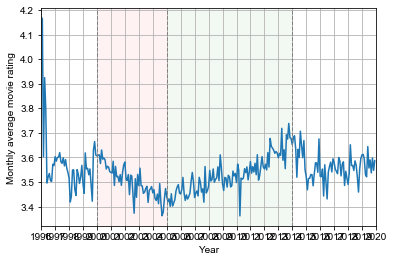

In [10]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
plt.style.use('seaborn-white')
ax.plot(rsp_time_series.index,rsp_time_series.values)
# title and labels, setting initial sizes
#fig.suptitle('Average movie ratings by year')
ax.set_xlabel('Year')
ax.set_ylabel('Monthly average movie rating')   # relative to plt.rcParams['font.size']

params = {'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)
plt.grid()

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.xlim("1996-1-1","2020-01-1")
plt.axvline(x="2000-01-1",linewidth=1, color='gray',ls="--")
plt.axvline(x="2005-01-1",linewidth=1, color='gray',ls="--")
plt.axvline(x="2014-01-1",linewidth=1, color='gray',ls="--")

plt.axvspan("2000-01-1", "2005-01-1", facecolor='r', alpha=0.05)
plt.axvspan("2005-01-1", "2014-01-1", facecolor='g', alpha=0.05)

#ax.text(1, 1, "Downward trend", fontsize=12)

plt.savefig('AMR.png', dpi = 300);

### Yearly Heat Map Plot 

In [11]:
rsp_time_series=rsp_time_series[rsp_time_series.index.year>1996]

In [12]:
groups=rsp_time_series.groupby(rsp_time_series.index.year)

emp=np.zeros(12*23)
mat=emp.reshape(23,12)
k=0
for year,group in groups:
    if len(group.values)==12:
        mat[k,]=group.values.reshape(1,-1)
    else:
        a=12-len(group.values)
        b=[None]*a # add None        
        mat[k,]=np.append(group.values,b).reshape(1,-1)
    k+=1

In [13]:
## Extract all months 
months_choices = []
for i in range(1,13):
    months_choices.append( dt.date(2008, i, 1).strftime('%B'))

months_choices

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

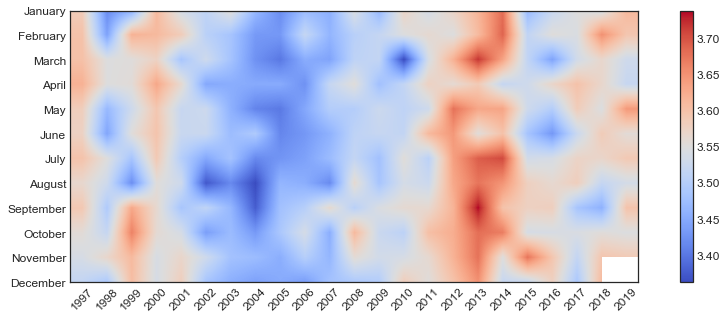

In [14]:
## plotting heatmap
fig, ax = plt.subplots(1,1)
plt.imshow(mat.T,interpolation='bilinear',cmap="coolwarm")

y_label_list = months_choices
ax.set_yticks(list(range(0,12)))
ax.set_yticklabels(y_label_list)


x_label_list = rsp_time_series.index.year.unique().tolist()
ax.set_xticks(list(range(0,23)))
ax.set_xticklabels(x_label_list)
plt.xticks(rotation=45)

plt.colorbar()
plt.savefig('HEAT.png', dpi = 300);

### Preparation and cleaning Movies dataset

In [15]:
movies=pd.read_csv("./datasets/IMDB Movie dataset/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
## extracting released time of rated movies 
movies['released_time'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)
print(movies.dtypes)
movies.dropna(inplace=True)
movies=movies.sort_values(by=["released_time"])
movies.iloc[-1,3]="1957"

movieId           int64
title            object
genres           object
released_time    object
dtype: object


In [17]:
movies=movies.sort_values(by=["released_time"])
movies.drop([43350,15036],inplace=True)

In [18]:
movies=movies.reset_index()
movies

,index,movieId,title,genres,released_time
0,35536,148054,Passage de Venus (1874),Documentary,1874
1,35533,148048,Sallie Gardner at a Gallop (1878),(no genres listed),1878
2,59938,202045,Athlete Swinging a Pick (1880),Documentary,1880
3,43771,166800,Buffalo Running (1883),(no genres listed),1883
4,35529,148040,Man Walking Around a Corner (1887),(no genres listed),1887
...,...,...,...,...,...
62009,60700,203934,Freaks (2019),Sci-Fi|Thriller,2019
62010,60698,203928,Echo in the Canyon (2019),Documentary,2019
62011,60657,203815,Guests (2019),Horror|Romance|Thriller,2019
62012,60721,203980,Immortality Corridor (2019),Drama|War,2019


In [19]:
movies.drop(["index"],axis=1,inplace=True)

In [20]:
print(movies.index[movies['released_time']=="1983)"][0])
print(movies.index[movies['released_time']=="2006–2007"][0])

18859
36670


In [21]:
movies.iloc[18859,3]=1983
movies.iloc[36670,3]=2006

In [22]:
## convert string to integer
movies.released_time=movies.released_time.astype(int)

In [23]:
TS=time_series.drop(["timestamp","parsed_time"],axis=1)

In [24]:
## Subsetting dataset i.e. green and red shaded area
df_2000_2005=TS[(TS.year>=2000) & (TS.year<=2005)].reset_index()
df_2005_2014=TS[(TS.year>2005) & (TS.year<2014)].reset_index()

### Comparing histogarms of ranked movies in two time periods

In [25]:
merged_2000_2005=pd.merge(df_2000_2005,movies,on="movieId",how="inner").set_index("date")
merged_2005_2014=pd.merge(df_2005_2014,movies,on="movieId",how="inner").set_index("date")

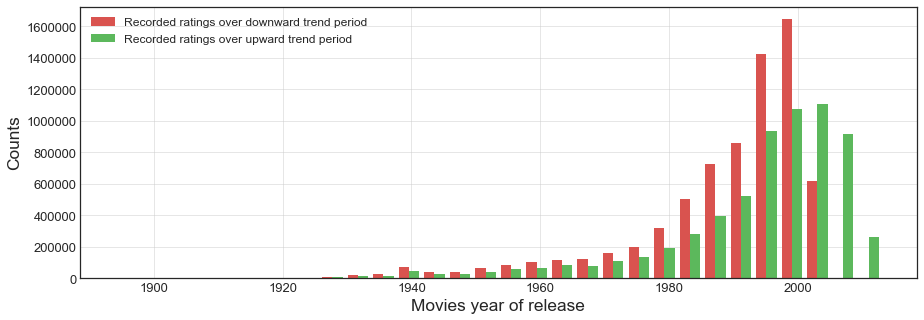

In [26]:
# Assign colors for each airline and the names
#colors = ['#D55E00', '#009E73']
colors=['#d9534f','#5cb85c']
names = ['Recorded ratings over downward trend period', 'Recorded ratings over upward trend period']
       
plt.figure(figsize=(15,5))
plt.hist([merged_2000_2005.released_time, merged_2005_2014.released_time], bins = 30,color = colors, label=names)

# Plot formatting
plt.legend()
plt.legend(loc = 'best')
plt.xlabel('Movies year of release')
plt.ylabel('Counts')
#plt.title('Distribution of movie release year rated by audience in two different time periods')
plt.grid(alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(fontsize="large")
plt.savefig('ToR.png', dpi = 300);

### Popular movies

Movie with ranking higher than 4 is considerd as popular


In [27]:
merged_2000_2005=pd.merge(df_2000_2005,movies,on="movieId",how="inner").set_index("date")
## popular movies
merged_2000_2005=merged_2000_2005[merged_2000_2005.rating>=4]

In [28]:
pop_movie_2000_2005=pd.merge(merged_2000_2005.groupby("movieId").mean().reset_index()[["movieId","rating"]],movies,on="movieId",how="inner")
pop_movie_2000_2005.head()

,movieId,rating,title,genres,released_time
0,1,4.420678,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,4.162268,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,4.224209,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,4.164430,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,4.204148,Father of the Bride Part II (1995),Comedy,1995


In [29]:
merged_2005_2014=pd.merge(df_2005_2014,movies,on="movieId",how="inner").set_index("date")
## popular movies
merged_2005_2014=merged_2005_2014[merged_2005_2014.rating>=4]

In [30]:
pop_movie_2005_2014=pd.merge(merged_2005_2014.groupby("movieId").mean().reset_index()[["movieId","rating"]],movies,on="movieId",how="inner")
pop_movie_2005_2014.head()

,movieId,rating,title,genres,released_time
0,1,4.364018,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,4.210992,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,4.194079,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,4.190476,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,4.265125,Father of the Bride Part II (1995),Comedy,1995


In [31]:
## all genres exist in the dataset
All_genres=["Action","Adventure","Animation","Children's","Comedy","Crime",
 "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical",
 "Mystery","Romance","Sci-Fi","Thriller","War","Western"]

In [32]:
def distributin_of_genres(dataset,selected_genres):
    counts=[]    
    for item in selected_genres:
        ls=[]
        for genre in dataset["genres"]:
            ls.append(item in genre)
        is_genre=pd.Series(ls)
        counts.append(len(dataset[is_genre]))
    return dict(zip(selected_genres, counts))

In [33]:
distributin_of_genres(pop_movie_2000_2005,All_genres)

{'Action': 1161,
 'Adventure': 836,
 'Animation': 210,
 "Children's": 0,
 'Comedy': 3006,
 'Crime': 941,
 'Documentary': 345,
 'Drama': 4199,
 'Fantasy': 426,
 'Film-Noir': 108,
 'Horror': 787,
 'Musical': 360,
 'Mystery': 431,
 'Romance': 1430,
 'Sci-Fi': 623,
 'Thriller': 1373,
 'War': 373,
 'Western': 217}

In [34]:
distributin_of_genres(pop_movie_2005_2014,All_genres)

{'Action': 2156,
 'Adventure': 1515,
 'Animation': 524,
 "Children's": 0,
 'Comedy': 5356,
 'Crime': 1889,
 'Documentary': 1210,
 'Drama': 8581,
 'Fantasy': 916,
 'Film-Noir': 238,
 'Horror': 1565,
 'Musical': 704,
 'Mystery': 926,
 'Romance': 2800,
 'Sci-Fi': 1095,
 'Thriller': 2701,
 'War': 809,
 'Western': 399}

In [35]:
df1=pd.DataFrame.from_dict(distributin_of_genres(pop_movie_2000_2005,All_genres),orient='index').reset_index()
df2=pd.DataFrame.from_dict(distributin_of_genres(pop_movie_2005_2014,All_genres),orient='index').reset_index()
result=pd.merge(df1,df2,on="index").set_index("index").T
result

index,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0_x,1161,836,210,0,3006,941,345,4199,426,108,787,360,431,1430,623,1373,373,217
0_y,2156,1515,524,0,5356,1889,1210,8581,916,238,1565,704,926,2800,1095,2701,809,399


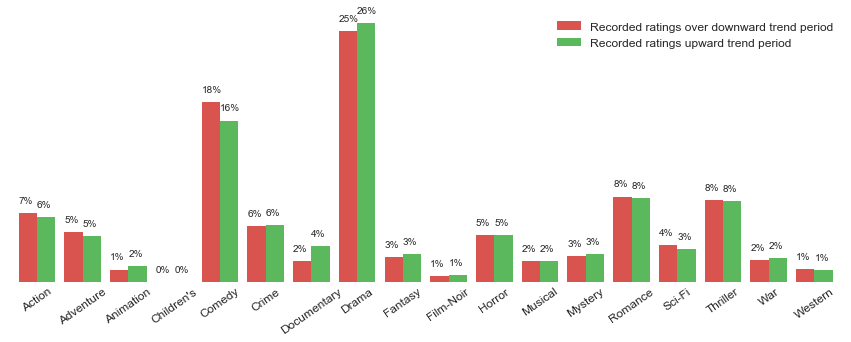

In [36]:
colors_list = ['#d9534f','#5cb85c']

# Change this line to plot percentages instead of absolute values
ax = (result.div(result.sum(1), axis=0)).T.plot(kind='bar',figsize=(15,5),width = 0.8,color = colors_list)
plt.legend(labels=['Recorded ratings over downward trend period', 'Recorded ratings upward trend period'],fontsize= 12)
#plt.title("Audience preferred movie genres ",fontsize= 16)
plt.xlabel("")
plt.xticks(fontsize=12)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
plt.xticks(rotation=35)

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

plt.savefig('Gm.png', dpi = 300);